In [1]:
import numpy as np
from embiggen.embedders.layers import GraphAttention
from ensmallen_graph.datasets.linqs import Cora
from ensmallen_graph.datasets.linqs.parse_linqs import get_words_data
from plot_keras_history import plot_history

In [2]:
cora = Cora()
features = get_words_data(cora)
cora = cora.filter_from_names(node_type_name_to_filter=['Word']).remove_edge_weights().remove_edge_types()
features = features.loc[cora.get_node_names()]
#cora = cora.generate_new_edges_from_node_features(features.values, neighbours_number=3, max_degree=3)
cora

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

The undirected graph Cora has 2708 nodes and 5278 unweighted edges, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44). The hash of the graph is 9982f2a4ae22d17d.

In [3]:
nodes_number = cora.get_nodes_number()

In [4]:
train_graph, validation_graph = cora.node_label_holdout(0.8, use_stratification=True)

In [5]:
A = np.zeros((cora.get_nodes_number(), cora.get_nodes_number()), dtype=float)
A[cora.get_source_node_ids(True), cora.get_destination_node_ids(True)] = 1.0

In [6]:
train_node_ids = np.array([
    node_id
    for node_id, node_type in enumerate(train_graph.get_node_type_ids())
    if node_type is not None
])

test_node_ids = np.array([
    node_id
    for node_id, node_type in enumerate(validation_graph.get_node_type_ids())
    if node_type is not None
])
validation_data = (
    test_node_ids,
    validation_graph.get_one_hot_encoded_node_types()[test_node_ids]
)

In [7]:
"""Graph Convolutional Neural Network (GCNN) model for graph embedding."""
from typing import Dict, List, Union

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from extra_keras_metrics import get_minimal_multiclass_metrics
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Attention, Embedding, Reshape, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.constraints import Constraint
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Model  # pylint: disable=import-error
from tensorflow.keras.optimizers import \
    Optimizer  # pylint: disable=import-error

from ensmallen_graph import EnsmallenGraph

In [8]:
node_ids = Input(
    shape=(1,), 
    name="NodeIds",
    dtype=tf.int64,
)

const_A = tf.constant(A, dtype=float)
const_A = const_A * const_A * const_A

all_node_features = tf.constant(features.values, dtype=float)

In [9]:
central_node_features = Embedding(
    weights=[all_node_features],
    trainable=False,
    input_length=1,
    input_dim=features.shape[0],
    output_dim=features.shape[1]
)(node_ids)

In [10]:
k = 30

In [11]:
reduced_central_node_features = Dense(k, activation='relu')(
    Dropout(0.25)(central_node_features)
)

reduced_all_node_features = Dense(k, activation='relu')(
    Dropout(0.25)(all_node_features)
)

In [12]:
smax =  tf.reshape(
    tf.nn.softmax(
        tf.matmul(
            reduced_central_node_features, 
            tf.transpose(reduced_all_node_features)
        )
    ), 
    [-1, 2708]
)

mask = tf.reshape(
    tf.cast(
        tf.nn.embedding_lookup(const_A, node_ids), 
        dtype=float
    ), 
    [-1, 2708]
)

att = tf.matmul(
    smax, # * mask,
    reduced_all_node_features,
)

In [13]:
output = Dense(7, activation="softmax")(att)

model = Model(
    inputs=node_ids,
    outputs=output,
    name="GAT"
)

In [14]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    weighted_metrics=get_minimal_multiclass_metrics()
)

In [15]:
model.summary()

Model: "GAT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NodeIds (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1433)           3880564   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1433)           0         
_________________________________________________________________
dense (Dense)                (None, 1, 30)             43020     
_________________________________________________________________
tf.linalg.matmul (TFOpLambda (None, 1, 2708)           0         
_________________________________________________________________
tf.nn.softmax (TFOpLambda)   (None, 1, 2708)           0         
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 2708)              0       

In [16]:
history = pd.DataFrame(model.fit(
    train_node_ids, train_graph.get_one_hot_encoded_node_types()[train_node_ids],
    validation_data=validation_data,
    epochs=1024,
    verbose=False,
    shuffle=True,
    batch_size=256,
    callbacks=[
        EarlyStopping(
            monitor="loss",
            min_delta=0.001,
            patience=40,
            mode="min",
        ),
        ReduceLROnPlateau(
            monitor="loss",
            min_delta=0.001,
            patience=10,
            factor=0.9,
            mode="min",
        ),
        TqdmCallback()
    ]
).history)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

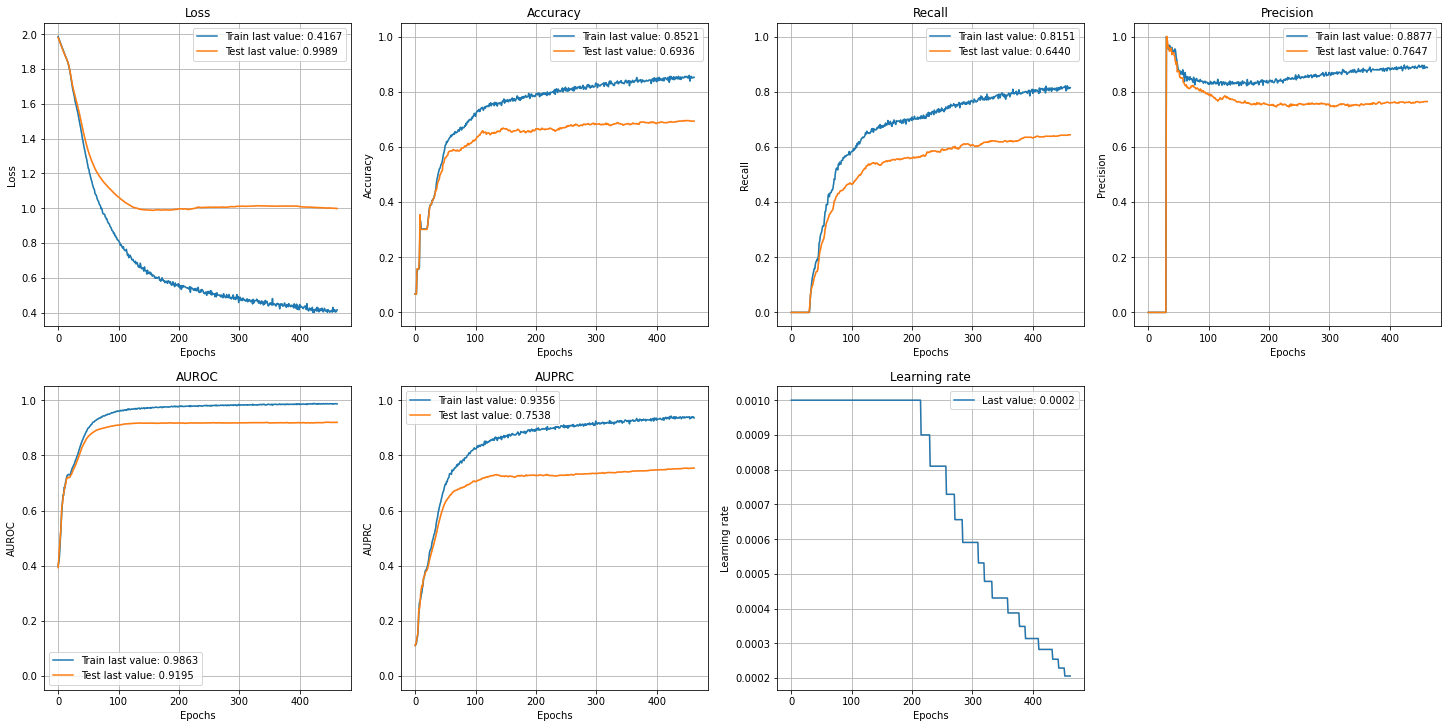

In [17]:
_ = plot_history(history)